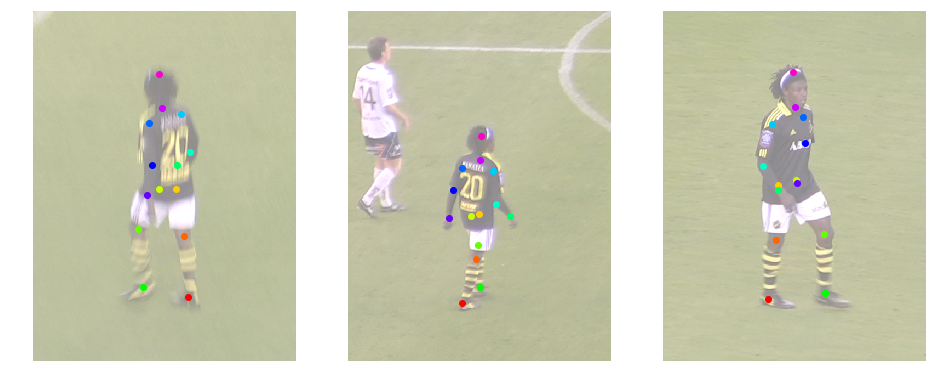

In [108]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir, isfile
from os import makedirs, listdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from math import floor, ceil

from pak.util.download import download
from pak.util.unzip import unzip


root = join(Settings['data_root'], 'football2')
if not isdir(root):
    makedirs(root)

def handle(seq_url, seq_dir, root, zipname):
    if not isdir(seq_dir):
        seq_zip = join(root, zipname)
        if not isfile(seq_zip):
            print("downloading ", seq_url)
            download(seq_url, seq_zip)

        print('unzipping..')
        unzip(seq_zip, root)

    
seq1_zipname = 'player1sequence1.zip'
seq1_url = 'http://www.csc.kth.se/cvap/cvg/MultiViewFootballData/player1sequence1.zip'
seq1_dir = join(root, 'Sequence 1')
handle(seq1_url, seq1_dir, root, seq1_zipname)

seq2_zipname = 'player1sequence2.zip'
seq2_url = 'http://www.csc.kth.se/cvap/cvg/MultiViewFootballData/player1sequence2.zip'
seq2_dir = join(root, 'Sequence 2')
handle(seq2_url, seq2_dir, root, seq2_zipname)

seq_dir = seq1_dir

colors = cs.lincolor(N + 2).astype('float32')/255

# ~~~ pos2d ~~~
pos2d_file = join(seq_dir, 'positions2d.txt')
assert isfile(pos2d_file)
pos2d = np.loadtxt(pos2d_file)
N = 14  # number joints
C = 3   # number cameras 
#T = len(listdir(join(seq_dir, 'Camera 1')))  # number frames
T = len(pos2d) / 2 / N / C
assert floor(T) == ceil(T)
T = int(T)

pos2d_result = np.zeros((2,N,C,T))
counter = 0
for t in range(T):
    for c in range(C):
        for n in range(N):
            for i in range(2):
                pos2d_result[i,n,c,t] = pos2d[counter]
                counter += 1
pos2d = pos2d_result

# ~~~ pos3d ~~~
pos3d_file = join(seq_dir, 'positions3d.txt')
assert isfile(pos3d_file)
pos3d = np.loadtxt(pos3d_file)
pos3d_result = np.zeros((3,N,T))
assert T == int(len(pos3d) / 3 / N)
counter = 0
for t in range(T):
    for n in range(N):
        for i in range(3):
            pos3d_result[i,n,t] = pos3d[counter]
            counter += 1
pos3d = pos3d_result

# ~~~ Cameras ~~~
cam_file = join(seq_dir, 'cameras.txt')
assert isfile(cam_file)
cams = np.loadtxt(cam_file)
cameras = np.zeros((2,4,C,T))
assert T == int(len(cams) / 2 / 4 / C)

counter = 0
for t in range(T):
    for c in range(C):
        for j in range(4):
            for i in range(2):
                cameras[i,j,c,t] = cams[counter]
                counter += 1
            
FRAME = 100

Im = []
for cam in ['Camera 1', 'Camera 2', 'Camera 3']:
    im_dir = join(seq_dir, cam)
    assert isdir(im_dir)
    im_name = join(im_dir, "%05d.png" % FRAME)
    assert isfile(im_name)
    im = cv2.cvtColor(cv2.imread(im_name), cv2.COLOR_BGR2RGB)
    Im.append(im)
Im = np.array(Im)

fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    joints = np.transpose(pos2d_result[:,:,cid,FRAME-1])
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid])
        

plt.show()

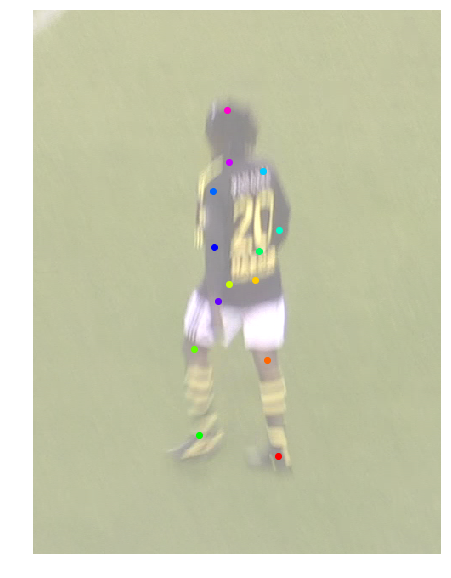

In [111]:
from math import cos, sin

cam1 = np.zeros((3,4))
cam1[0:2,:] = cameras[:,:,0, FRAME-1]
cam1[2,3] = 1

pts3d = np.transpose(pos3d[:,:,FRAME-1])


im = Im[0]

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111); ax.axis('off')
ax.imshow(im, alpha=0.5)

for jid, (x,y,z) in enumerate(pts3d):
    p3d = np.array([x,y,z,1])
    p2d = cam1 @ p3d
    a,b,c = p2d
    ax.scatter(a/c, b/c, color=colors[jid])

plt.show()